<hr style="height:5px;border-width:0;color:orange;background-color:orange">
    <center> <span style="font-size: 38px;"> Time Series Analysis: Sales prediction </span> </center>

+ Author: **Alejandro Sánchez Silvestre**
+ Date: **March 2024**
+ Module: **Time Series**

<hr style="height:5px;border-width:0;color:orange;background-color:orange">

# **Intro**
Los datos provienen de una compañia del sector retail que vende productos online a distintos paises europeos (UK, Denmark...). El objetivo consiste en predecir cuál será su beneficio diario durante los próximos meses.
Se ha fijado un **horizonte de predicción de tres meses** teniendo en cuenta la última fecha de transacciones disponible (el 9 de Diciembre de 2023)


La tarea central consistirá en elaborar un informe que muestre los
aspectos más relevantes relacionados con la evolución de los beneficios de dicha compañia durante el último ejercicio y las predicciones de beneficios para el próximo trimestre.


**Estructura del informe**
El informe debería tener una estructura con los siguientes apartados


**3. Análisis de Resultados y Selección de Modelo**
- Comparación de modelos.
- Selección de modelo basada en criterios y métricas.

**ROAD MAP Y OUTLINE**: 
- **Intro**
- **Pipeline summary**: 
    1. **Comprensión del problema/negocio** 
    2. **Entendimiento de los datos**
        - Énfasis en variables temporales y estacionalidad.
        - Análisis de autocorrelación y autocorrelación parcial.
        - Descomposición de los componentes de la serie temporal
    3. **Preprocesamiento**: tratamiento de datos y tipos, fechas, nulos, duplicados y feature engeneering si necesario.
    4. **Modelización**: Desarrollo de Métodos (SARIMAX, Prophet, Boosting, Otros)
    5. **Evaluacion resultados**:
        - Comparación de modelos.
        - Selección de modelo basada en criterios y métricas. XGBoost con 7 features importantes + target
   
- **Conclusion**



de tutorias de Jorge:
### ROADMAP


3. Preparacion modelo series temporales
- Creacion df(index tiempo y variable a predecir)
- Descomposicion Temporal (Tendencia, Estacionalidad, Ruido)
- Evaluacion estacionaridad (Dickey-Fuller) y tendencia (Mann-Kendall). Diferenciacion/detrending si fuera necesario
- Autocorrelacion

4. ARIMA (AutoARIMA)
- Busqueda mejores parametros
- Ajuste del modelo
- Prediccion y visualizacion de la prediccion.
- Visualizacion de diagnisticos
- Obtención primera metrica (baseline)

5. Second Iteration: Prophet, XGBoost others...
- Comparacion distintos modelos.
- Validacion cruzada/split validation.





<hr style="height:5px;border-width:0;color:orange;background-color:orange">

In [5]:
# Manipulación y Limpieza de Datos
import pandas as pd
import numpy as np

# Manejo de Fecha y Hora
from datetime import datetime, timezone, time, timedelta, date

# Visualización de Datos
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# herramienta de analitica
# import skimpy as sk

# Análisis de Series Temporales
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.stattools import adfuller
# from pmdarima import auto_arima
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.stats.diagnostic import het_white
# import pymannkendall as mk
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score ,mean_absolute_percentage_error


# Modelos
# from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
# from statsmodels.tsa.statespace.sarimax import SARIMAX


# Prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

# Otros
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context
import warnings
warnings.filterwarnings('ignore')

<a id='seccion1'></a>
## **1. Comprension del Problema/Negocio**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

El problema a resolver es conceptualmente sencillo, debemos predecir las ventas globales en la determinada compañia. Proximamente crearemos una columna con el valor de venta que será la variable a predecir. 

De momento tenemos las siguientes columnas:

- **InvoiceNo:** Numero de factura/transaccion
- **StockCode**: codigo de articulo unico
- **Description**: breve descripcion del articulo en cuestion
- **Quantity**: unidades vendidas en dicha transaccion.
- **InvoiceDate**: fecha y hora de compra/transaccion 
- **UnitPrice**: precio del articulo en cuestion
- **CustomerID:** ID del cliente que ha realizado la transaccion
- **Country**: Pais donde se ha realizado la transaccion.


De todas estas las mas importantes en este proyecto serán el **Quantity** y **UnitPrice** ya que con estas dos podremos calcular el valor, variable Y a predecir, y la **InvoiceDate** que será nuestra variable dependiente temporal.


In [6]:
df=pd.read_csv('online_retail_sales.csv')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2023-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2023-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2023-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2023-12-09 12:50:00,4.15,12680.0,France


In [52]:
import skimpy as sk
sk.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 541909 │ │ string      │ 5     │                                                          │
│ │ Number of columns │ 8      │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA       ┃ NA %   ┃ mean   ┃ sd    ┃ p0       ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ Quantity      │        0 │      0 │    9.6 │   220 │   -81000 │      1 │      3 │     10 │  81000 │     ▇  │  │
│ │ UnitPrice     │        0 │      0 │    4.6 │    97 │   -11000 │    1.2 │    2.1 │    4.1 │  39000 │    ▇   │  │
│ │ CustomerID    │   135080 │  24.93 │  15000 │  1700 │    12000 │  14000 │  15000 │  17000 │  18000 │ ▇▆▇▆▆▇ │  │
│ └───────────────┴──────────┴────────┴────────┴───────┴──────────┴────────┴────────┴────────┴────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA         ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ InvoiceNo                │          0 │          0 │                           1 │                  541909 │  │
│ │ StockCode                │          0 │          0 │                           1 │                  541946 │  │
│ │ Description              │       1454 │       0.27 │                         4.6 │                 2506861 │  │
│ │ InvoiceDate              │          0 │          0 │                           2 │                 1083818 │  │
│ │ Country                  │          0 │          0 │                         1.9 │                 1038670 │  │
│ └──────────────────────────┴────────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Aqui ya podemos ver un analisis preliminar de nuestras columnas, de momento los Nulos de la columna Description y Customer ID, diria de eliminarlos. De hecho por el momento no nos preocupa porque son columnas que no usaremos en los datos de prediccion.

<a id='seccion2'></a>
## **2. Entendimiento de los datos**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

In [7]:
# Antes de nada Cambiamos el tipo de dato a datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# y convertimos únicamente a fecha ya que haremos la serie temporal por días únicamente. De paso nos creamos dos columnas.
df['Date'] = df['InvoiceDate'].dt.date
df['Hour']= df['InvoiceDate'].dt.time


In [8]:
# eliminamos duplicados
display(df.duplicated().sum())
df.drop_duplicates(inplace=True)
display(df.duplicated().sum())

5268

0

In [9]:
# Como lo que queremos modelizar es el beneficio diario vamos a crear una df agrupando por dia y valor total.
# Creamos una columna nueva llamada value que agrupa el valor de la venta
df['value']=df['Quantity']*df['UnitPrice']

<AxesSubplot:xlabel='Date', ylabel='value'>

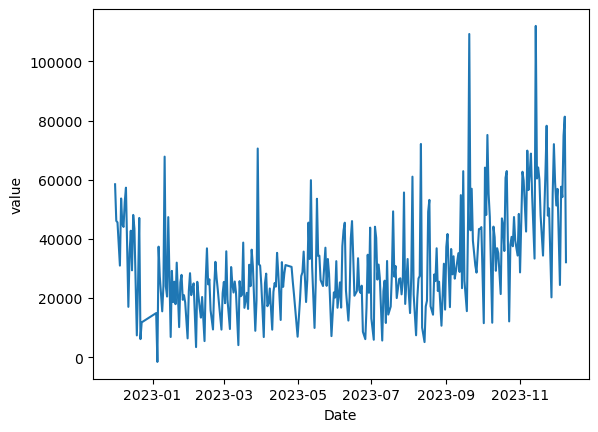

In [10]:
# visualizamos las el valor de venta('value') a lo largo de todo el periodo


sns.lineplot(data=df.groupby('Date')['value'].sum().reset_index(), x='Date', y='value')


<AxesSubplot:xlabel='Country', ylabel='count'>

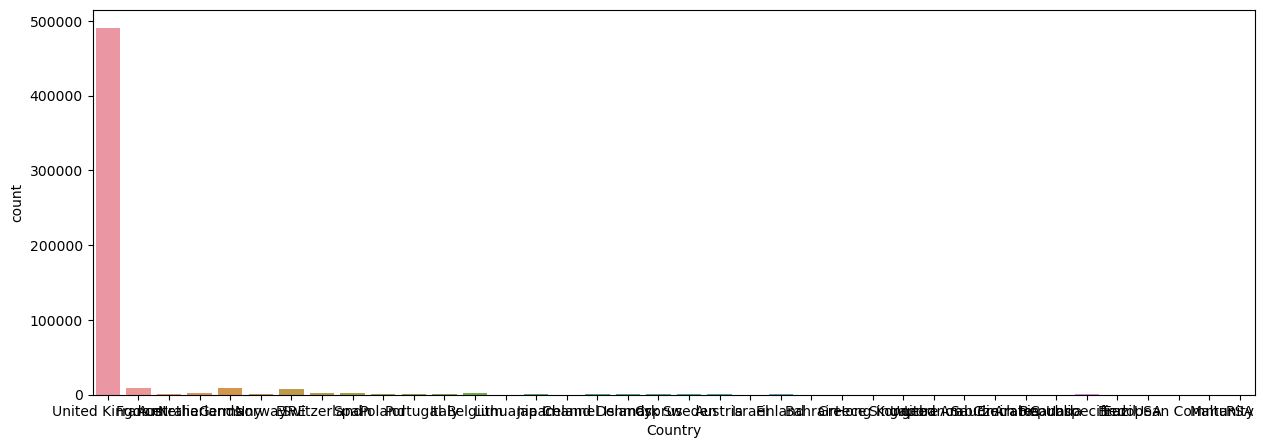

In [11]:
# y visualizamos tambien la distribucion de los valores de venta en la variable country
plt.figure(figsize=(15,5))

sns.countplot(data=df, x='Country')

# vemos que practicamente la mayoria de las ventas son en UK

In [58]:
# evaluamos cuanto % del negocio corresponde a UK (91% de observaciones)
df.groupby('Country')['value'].sum().sort_values(ascending=False)/df.groupby('Country')['value'].sum().sort_values(ascending=False).sum()

# parece que tiene sentido, el 84% del negocio corresponde a UK.

Country
United Kingdom         0.84
Netherlands            0.03
EIRE                   0.03
Germany                0.02
France                 0.02
Australia              0.01
Switzerland            0.01
Spain                  0.01
Belgium                0.00
Sweden                 0.00
Japan                  0.00
Norway                 0.00
Portugal               0.00
Finland                0.00
Channel Islands        0.00
Denmark                0.00
Italy                  0.00
Cyprus                 0.00
Austria                0.00
Hong Kong              0.00
Singapore              0.00
Israel                 0.00
Poland                 0.00
Unspecified            0.00
Greece                 0.00
Iceland                0.00
Canada                 0.00
Malta                  0.00
United Arab Emirates   0.00
USA                    0.00
Lebanon                0.00
Lithuania              0.00
European Community     0.00
Brazil                 0.00
RSA                    0.00
Czech Republ

In [59]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Hour,value
count,536641,536641,535187,536641.00,536641,536641.00,401604.00,536641,536641,536641,536641.00
unique,25900,4070,4223,NaN,NaN,NaN,NaN,38,305,774,NaN
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom,2023-12-05,15:56:00,NaN
freq,1114,2301,2357,NaN,NaN,NaN,NaN,490300,5292,2623,NaN
mean,NaN,NaN,NaN,9.62,2023-07-04 08:57:06.087421440,4.63,15281.16,NaN,NaN,NaN,18.12
min,NaN,NaN,NaN,-80995.00,2022-12-01 08:26:00,-11062.06,12346.00,NaN,NaN,NaN,-168469.60
25%,NaN,NaN,NaN,1.00,2023-03-28 10:52:00,1.25,13939.00,NaN,NaN,NaN,3.75
50%,NaN,NaN,NaN,3.00,2023-07-19 14:04:00,2.08,15145.00,NaN,NaN,NaN,9.87
75%,NaN,NaN,NaN,10.00,2023-10-18 17:05:00,4.13,16784.00,NaN,NaN,NaN,17.40
max,NaN,NaN,NaN,80995.00,2023-12-09 12:50:00,38970.00,18287.00,NaN,NaN,NaN,168469.60


Tenemos unos 4.000 productos distintos, que segun los datos registros se venden mayormente en UK desde 1 de Diciembre de 2022 hasta el 9 de Diciembre de 2023.
El precio medio  es de 4.63

Negativos: existen negativos en vantidades y precios, esto ya lo veremos mas adelante.

Me sorprende tambien en cantidades la cifra 80995 siendo la maxima pero tambien la minima (-80995)

In [12]:
# vamos a ver cuanto supone en total de valores negativos:

print('total de valores negativos: ',df[df['Quantity']<0]['value'].sum())

print('Total de valor negocio:',df[df['value']>0]['value'].sum(),'representando los negativos un: ',(df[df['Quantity']<0]['value'].sum())/(df[df['value']>0]['value'].sum())*100,'%')

total de valores negativos:  -893979.73
Total de valor negocio: 10642110.804 representando los negativos un:  -8.400398628287013 %


In [61]:
df[df['Quantity']<0].Description.value_counts()

# la mayoria de negativos se tratan de operaciones Manuales (errores solventados por el dependiente quizas?), postage (gastos envio) y checkes entre otros (tarteros, sets de mermeladas...)

Description
Manual                               244
REGENCY CAKESTAND 3 TIER             180
POSTAGE                              126
check                                120
JAM MAKING SET WITH JARS              87
                                    ... 
SET OF 6 T-LIGHTS CACTI                1
SET/6 FROG PRINCE T-LIGHT CANDLES      1
DENIM PATCH PURSE PINK BUTTERFLY       1
2 PICTURE BOOK EGGS EASTER CHICKS      1
PAPER CRAFT , LITTLE BIRDIE            1
Name: count, Length: 2110, dtype: int64

In [62]:
df[(df['Description']=='POSTAGE')|(df['Description']== 'Manual') | (df['Description']=='check')].describe()

# veo que aqui hay valores tanto negativos como positivos. Voy a eliminarlos del DF ya que serian ''gastos'' y no impactarian positivamente en el valor diario a predecir.
# No son articulos que se venden, por lo tanto no estarian generando facturacion. Estos calculos de gastos (CAPEX) se harian en otro tipo de analisis.

,Quantity,InvoiceDate,UnitPrice,CustomerID,value
count,1978.00,1978,1978.00,1656.00,1978.00
mean,-3.08,2023-07-13 23:00:53.569262080,131.87,13560.09,-1.42
min,-3000.00,2022-12-01 08:45:00,0.00,12348.00,-38970.00
25%,1.00,2023-04-07 12:00:15,5.55,12528.00,0.00
50%,1.00,2023-08-01 11:44:00,18.00,12682.00,18.00
75%,3.00,2023-10-25 14:15:45,28.00,14048.50,54.00
max,1600.00,2023-12-09 12:16:00,38970.00,18283.00,8142.75
std,104.41,NaN,999.23,1695.24,1023.03


In [13]:
# eliminamos los valores negativos por el momento
df=df[(df['Quantity']>0)&(df['value']>0)]
# y tambien las observaciones que correspondan a Manual, POSTAGE y Check.
df= df[(df['Description']!='POSTAGE')&(df['Description']!= 'Manual') & (df['Description']!='check')]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Hour,value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,2022-12-01,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,2022-12-01,08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2023-12-09 12:50:00,0.85,12680.0,France,2023-12-09,12:50:00,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2023-12-09 12:50:00,2.10,12680.0,France,2023-12-09,12:50:00,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2023-12-09 12:50:00,4.15,12680.0,France,2023-12-09,12:50:00,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2023-12-09 12:50:00,4.15,12680.0,France,2023-12-09,12:50:00,16.60


In [14]:
# Agrupamos por dia y mes para poder visualizar algun patron en las ventas, por ejemplo, en verano se vende menos que ne inviernos o los lunes se vende mas que los vienes.

df['week_day'] = df['InvoiceDate'].dt.day_name()
df['month'] = df['InvoiceDate'].dt.month_name()

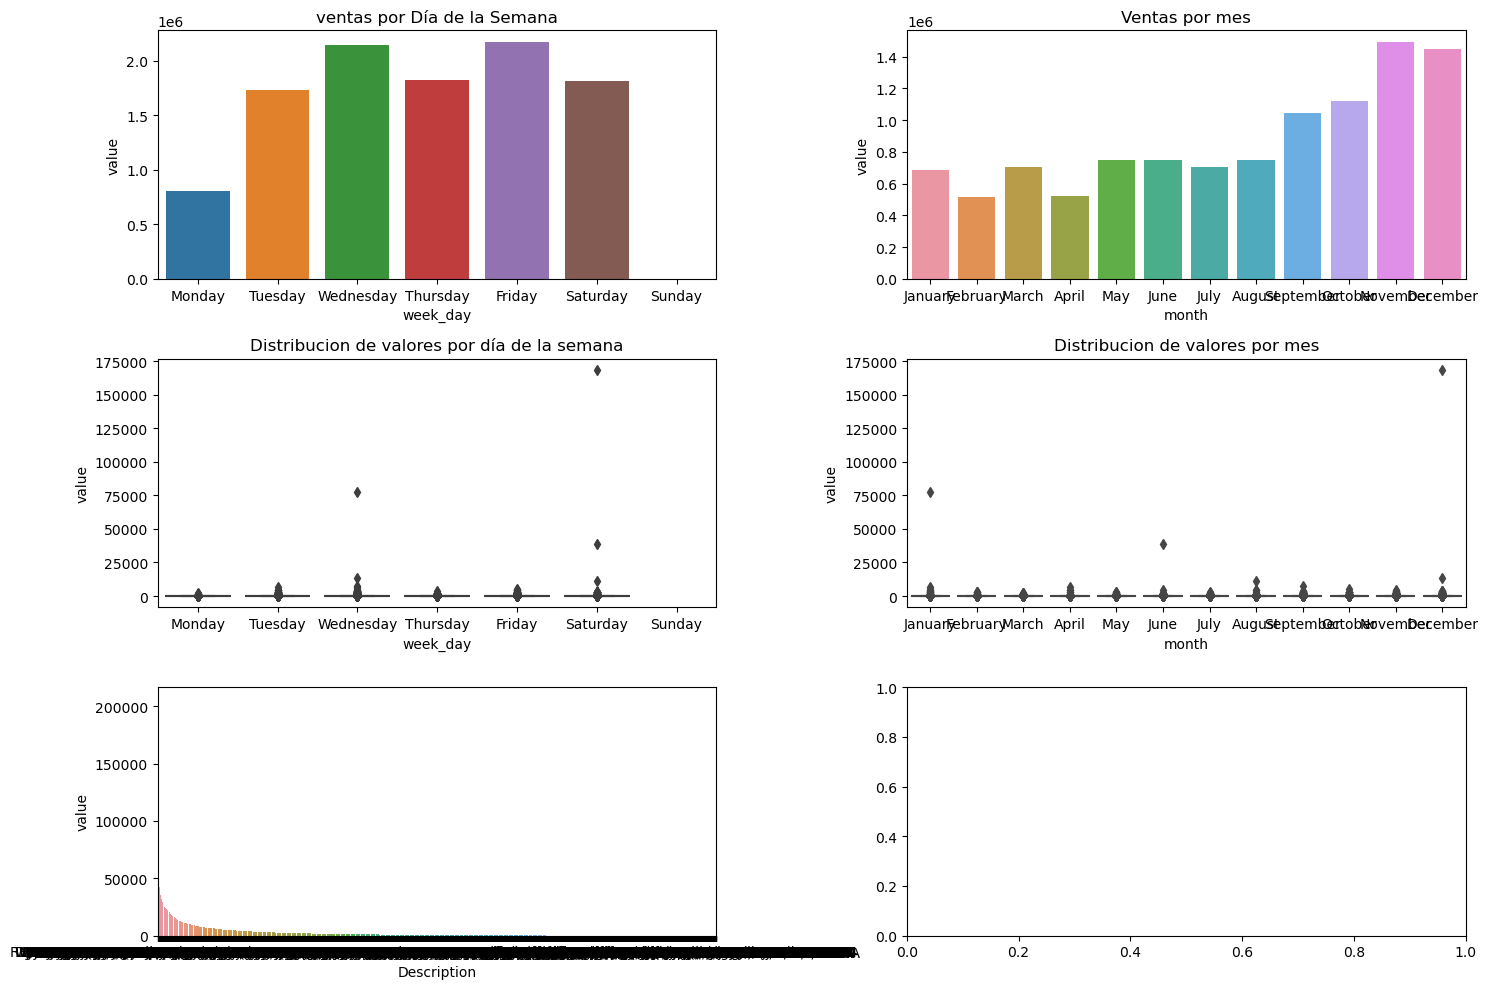

In [65]:
# Vamos a visualizar distintos graficos en distintos subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# Ventas por dia de la semana
sns.barplot(data=df, x='week_day', y='value',
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            estimator=np.sum, ci=None, ax=axs[0, 0])
axs[0, 0].set_title('ventas por Día de la Semana')

# Ventas por mes
sns.barplot(data=df, x='month', y='value', order= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
            estimator=np.sum, ci=None, ax=axs[0, 1])
axs[0, 1].set_title('Ventas por mes')

# Distribucion valores por dia de la semana

sns.boxplot(data=df, x='week_day', y='value',order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ax=axs[1, 0])
axs[1, 0].set_title('Distribucion de valores por día de la semana')

# Distribucion valores a lo largo del año

sns.boxplot(data=df, x='month', y='value', order= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ax=axs[1, 1])
axs[1, 1].set_title('Distribucion de valores por mes')

# distribucion de ventas por productos.

sns.barplot(data= df.groupby('Description')['value'].sum().sort_values(ascending=False).reset_index(), 
            x='Description', y='value', estimator=np.sum, ci=None, ax=axs[2, 0])


plt.tight_layout()
plt.show()

**Comentario distribucion semanal y anual**

Vemos que los miercoles y viernes son los dias que mas compras hay lo cual tiene su logica (la gente va a hacer la compra entre semana porque el lunes esta algo cansada y el viernes puede ser que compres algo caro para disfrutar el fin de semana). En el grafico anual vemos que los meses donde mas ventas hay es noviembre y diciembre... podria esto coincidir con las festividades de navidad, comidas familiares y etc.

Me parece coherente lo que estoy viendo hasta ahora.

En los graficos inferiores podemos ver algunos outliers que pueden darnos pistas. Se tratan de pedidos muy grandes, quizas de distribuidores? 

Por ultimo la distribucion de productos respecto a las ventas. Parece una distribucion normal de ventas.

Todo normal hasta aqui.

<a id='seccion3'></a>
## **2. Preprocesamiento**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

En esta seccion procesaremos los datos previo a introducirlo en el modelo de regresion.

### 2.1 Tratamiento de nulos

In [66]:
# Tenemos los nulos en  unicamente Customer ID...lo que por el momento nos da un poco igual ya que queremos cuantificar el valor total.
# Al haber eliminado nega
df.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132121
Country             0
Date                0
Hour                0
value               0
week_day            0
month               0
dtype: int64

### 2.2 Preparacion Modelo Series Temporales

In [67]:
# creamos df para agrupar por fecha y valor total.
df_ax= df.groupby('Date')['value'].sum().reset_index()
df_ax=df_ax.set_index('Date')
df_ax= df_ax.asfreq('D')
df_ax

,value
Date,
2022-12-01,58669.59
2022-12-02,47611.42
2022-12-03,46550.38
2022-12-04,NaN
2022-12-05,30908.67
...,...
2023-12-05,87988.49
2023-12-06,55993.69
2023-12-07,74675.55


In [68]:
# al transformar el df con los indices a fecha se me han generado 69 nulos (dias que no abre la tienda)
df_ax.isna().sum()

value    69
dtype: int64

In [69]:
px.line(df_ax)

# Aqui podemos ver el grafico del valor total diario a lo largo del tiempo.

# existen unos gaps 
# el primero corresponde: periodo 23 dic-4 Jan (bank holidays christmast+new year eve)
# el segundo corresponde: periodo 21 April - 26 April (easter)

# luego los gaps mas pequeños corresponden a los fines de semana(supongo)

# Esto mas tarde lo cruzaremos con los periodos de vacaciones(UK)

In [70]:
# antes de descomponer la serie necesitamos eliminar los nulos de los gaps. 
# vamos a asignar 0 a los nulos ya que esos dias no se vende (intuyo que las tiendas estan cerradas)

df_ax.fillna(0,inplace=True)

In [71]:
px.line(df_ax)

### 2.3 Descomposicion Temporal Serie

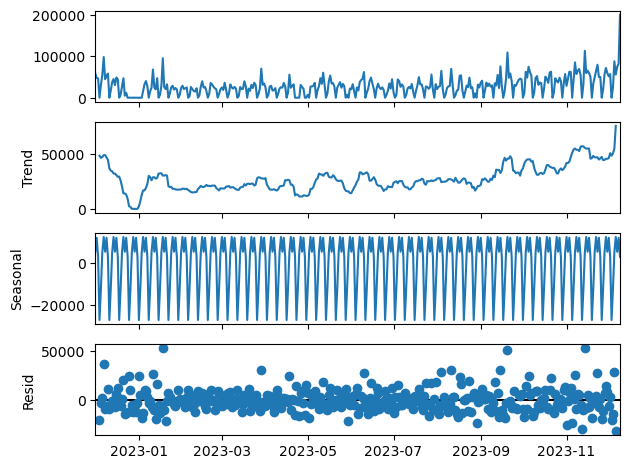

In [72]:
# Descomponemos la serie temporal para identificar tendencis, estacionalidad y ruido
result = seasonal_decompose(df_ax, model = 'additive', period = 7)
result.plot()
plt.show()

# vemos en la grafica de trend y seasonal que hay unos gaps comentados anterioremente.
# respecto a la estacionalidad, ajustando los datos a 7 dias(semanal) podemos apreciar que hay un pico qeu luego vuelve a bajar,
#  intuyo que será los fines de semana y luego el resto de la semana.

# respecto al ruido, se distribuye como esperabamos , viendo algun que otro outlier.




In [73]:
# Añadimos el resultado de la descomposicion nuestra df de trabajo.

df_ax['observed'] = result.observed
df_ax['trend'] = result.trend
df_ax['seasonal'] = result.seasonal
df_ax['residual'] = result.resid


df_ax.head()

,value,observed,trend,seasonal,residual
Date,,,,,
2022-12-01,58669.59,58669.59,NaN,5659.63,NaN
2022-12-02,47611.42,47611.42,NaN,12368.21,NaN
2022-12-03,46550.38,46550.38,NaN,3207.36,NaN
2022-12-04,0.00,0.00,48096.58,-27204.51,-20892.07
2022-12-05,30908.67,30908.67,46127.12,-12124.27,-3094.18


In [74]:
# Nos quedamos con el valor y el estimado para compararlos graficamente mas tarde

# Sumamos la tendencia y la estacionalidad para obtener el valor estimado
df_ax['estimated'] = df_ax['trend'] + df_ax['seasonal']
df_matrix = df_ax[['value', 'estimated']].copy()
df_matrix = df_matrix[df_matrix['estimated'].isna() == False]
df_matrix.head(5)

,value,estimated
Date,,
2022-12-04,0.00,20892.07
2022-12-05,30908.67,34002.85
2022-12-06,54522.72,52261.23
2022-12-07,98413.26,61340.91
2022-12-08,44883.40,54263.38


In [75]:
px.line(df_matrix)

# Vemos que mas o menos sigue la linea general dejando fuera registros con valores muy altos.

### 2.4 Metricas  
Añadimos todas las metricas a una tabla para poder visualizarlas

In [76]:
# añadimos las metricas a una tabla para poder visualizarlas

metrics = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE', 'R2'])
metrics['value'] = [np.nan, np.nan, np.nan, np.nan, np.nan]

# calculamos las metricas
metrics['value']['MAE'] = mean_absolute_error(y_pred = df_matrix['estimated'], y_true = df_matrix['value'])
metrics['value']['MSE'] = mean_squared_error(y_pred = df_matrix['estimated'], y_true = df_matrix['value'])
metrics['value']['RMSE'] = np.sqrt(metrics['value']['MSE'])
metrics['value']['MAPE'] = mean_absolute_percentage_error(y_pred = df_matrix['estimated'], y_true = df_matrix['value'])
metrics['value']['R2'] = r2_score(y_pred = df_matrix['estimated'], y_true = df_matrix['value'])

# visualizamos tabla
pd.set_option('display.float_format', '{:.2f}'.format)  
metrics

,value
MAE,8491.96
MSE,135326114.47
RMSE,11632.98
MAPE,8124898692752616448.00
R2,0.69


#### Comentario evaluacion metricas.

Las métricas comunes utilizadas en series temporales para evaluar el rendimiento de modelos predictivos son:


**MAE (Error Absoluto Medio)**:7561.16
Significado: Representa el promedio de las diferencias absolutas entre las predicciones y las observaciones reales. Mide la magnitud promedio de los errores.
Valores aceptables: Cuanto más bajo, mejor. Se interpreta directamente en la unidad de la variable objetivo.   La media es de mean=23055.03, entonces si hay cierto error (7561)


**RMSE (Error Cuadrático Medio)**:10837.31
Significado: Es la raíz cuadrada del promedio de los errores al cuadrado. Similar al MAE, pero penaliza más los errores grandes.
Valores aceptables: Cuanto más bajo, mejor. Se interpreta en la misma unidad que la variable objetivo. Esto es bastante alto a mi parecer


**MAPE (Error Porcentual Absoluto Medio)**:8,124e+18
Significado: Calcula el promedio de los errores porcentuales absolutos en relación con las observaciones reales.
Valores aceptables: Como regla general, valores más bajos son mejores. Sin embargo, puede haber casos en los que el MAPE sea alto debido a denominadores pequeños.
Esto me parece una barbaridad


**R2 (Coeficiente de Determinación)**: 0.66415
Significado: Mide la proporción de la variación en la variable dependiente que es predecible a partir de las variables independientes. Un valor de 1 indica una predicción perfecta, mientras que 0 indica que el modelo no explica la variabilidad de los datos.
Valores aceptables: Cuanto más cercano a 1, mejor. Un valor negativo puede indicar un rendimiento deficiente.



*En definitiva tenemos unos valores bastante feos, pero es normal, aun no hemos adaptado a un modelo realmente diseñado para predecir los datos.*



### 2.5 Tendencia y Estacionaridad


Ahora vamos a utilizar los siguientes test:
- Test de Mann-Kendall para detectar tendencias en series temporales, identificando si hay una tendencia monótona.
- Test ADF (Dickey-Fuller Aumentado) comprueba la estacionariedad, esencial para modelar adecuadamente, al determinar la presencia de una raíz unitaria que indica no estacionariedad debido a tendencias o patrones persistentes.

 Estos tests son cruciales para la preparación de datos y la selección de modelos de series temporales, ya que algunos modelos de predicción requieren datos estacionarios para funcionar de manera óptima

In [77]:
import pymannkendall as mk
from statsmodels.stats.diagnostic import het_white

def check_trend(time_series, alpha=0.05):
    """
    Perform the Mann-Kendall test for stationarity on a time series.
    
    H0: No monotonic trend --> Stationary
    Ha : Monotonic trend is present --> Non-Stationary (i.e.  trend exists)
    
    Assumptions
    
    - No correlation
    - No seasonality



    Parameters:
    - time_series: pandas Series or DataFrame column containing the time series data.
    - alpha: Significance level for the test.

    Returns:
    - result: pymannkendall test result object.
    """
    result = mk.original_test(time_series, alpha=alpha)
    return result

In [78]:
df_ax.drop(labels=['observed','trend','seasonal','residual','estimated'],axis=1,inplace=True)
df_ax

,value
Date,
2022-12-01,58669.59
2022-12-02,47611.42
2022-12-03,46550.38
2022-12-04,0.00
2022-12-05,30908.67
...,...
2023-12-05,87988.49
2023-12-06,55993.69
2023-12-07,74675.55


In [79]:
check_trend(df_ax, alpha=0.05)

# Tenemos un p-value de p=9.121081667728959e-11 (proximo a 0), entonces podemos asumir que la serie tiene tendencia (rechazamos hipotesis nula de estacionaridad)

Mann_Kendall_Test(trend='increasing', h=True, p=5.359956922745823e-11, z=6.56057786349442, Tau=0.22650571317973936, s=15799.0, var_s=5798558.333333333, slope=65.65389189189192, intercept=13454.549162162157)

In [80]:
# Check stationarity

from statsmodels.tsa.stattools import adfuller

result = adfuller(df_ax, autolag='AIC') # chooses the number of lags that renders the lowest AIC

#to help you, we added the names of every value
dict(zip(['adf', 'pvalue', 'n_lags', 'n_observations', 'critical' 'values', 'icbest'], result))

{'adf': -0.6589326392802688,
 'pvalue': 0.8571021466608073,
 'n_lags': 13,
 'n_observations': 360,
 'criticalvalues': {'1%': -3.448645946352023,
  '5%': -2.869602139060357,
  '10%': -2.5710650077160495},
 'icbest': 7912.731444303068}

#### Comentario tendencia y estacionaridad

Para la tendencia despues de aplicar la funcion check_trend (Mann-Kendall), tenemos un p-value de p=9.121081667728959e-11 (proximo a 0), entonces podemos asumir que la serie tiene tendencia (rechazamos hipotesis nula de estacionaridad). Recordemos que si p-value <0.05 (alpha) rechazamos hipotesis nula. 

Respecto al test ADF (Dickey-Fuller) el pvalue = 0.91 por lo que podemos rechazar la hipotesis alternativa de que la serie temporal es estacionaria como nos venia advirtiendo el test de Mann-Kendall. Tendremos que hacerla estacionaria mas adelante y eliminar la tendencia para que nuestro modelo funcione correctamente

En resumen , la serie tiene tendencia y no es estacionaria.

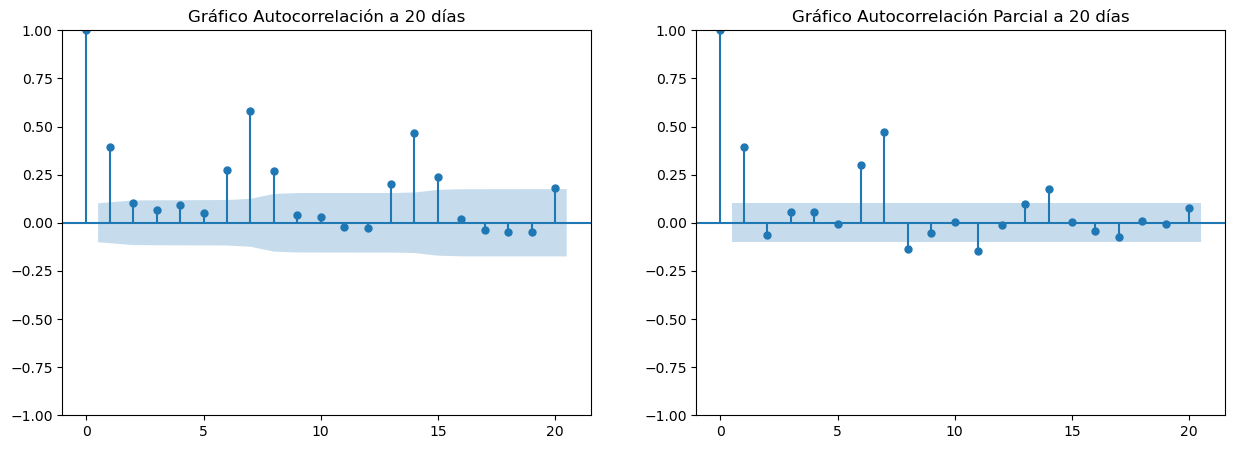

In [81]:
# Ahora vamos a graficar los graficos de autocorrelacion a 20 dias para ver si hay algun patron en la serie temporal

# generamos los subplots

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(df_ax, lags=20, ax=axs[0])
axs[0].set_title('Gráfico Autocorrelación a 20 días')

plot_pacf(df_ax, lags=20, ax=axs[1])
axs[1].set_title('Gráfico Autocorrelación Parcial a 20 días')

plt.show()


# En los graficos de autocorrelacion vemos que hay retardos importantes que cada 7 retardos saltan. Esto supongo que tiene relacion con la semana. Imagino que hay un dia
# de la semana que se vende mas que ninguno siempre, por ejemplo, la gente suele hacer las compras los miercoles o los viernes. Tambien que los domingos cierran y quizas 
# por eso detecta patron.

#### Proximos pasos
Dado que he identificado la presencia de tendencia pero la falta de estacionaridad en mis datos de series temporales, hay varios pasos que consideraré para construir mi modelo de predicción. Aquí algunas acciones que tomaré:

**Diferenciación:** Aplicaré diferenciación para hacer mis datos estacionarios. Realizaré la primera diferencia (df.diff()) y verificaré nuevamente la estacionaridad con el test de Dickey-Fuller. Continuaré diferenciando hasta lograr la estacionaridad.

**Transformación:** Si la tendencia es evidente pero difícil de eliminar, aplicaré alguna transformación a mis datos, como la transformación logarítmica o la raíz cuadrada. Luego, verificaré la estacionaridad nuevamente.

**Modelo ARIMA:** Después de obtener una serie temporal estacionaria, consideraré utilizar un modelo ARIMA para predecir los valores futuros. ARIMA es eficaz para manejar datos con tendencia y estacionalidad.

**Validación del Modelo:** Dividiré mis datos en conjuntos de entrenamiento y prueba. Entrenaré el modelo en el conjunto de entrenamiento y evaluaré su rendimiento en el conjunto de prueba. Ajustaré los parámetros del modelo según sea necesario.

**Optimización del Modelo:** Experimentaré con diferentes configuraciones de hiperparámetros, realizaré validación cruzada y ajustaré mi modelo para mejorar su rendimiento.

Estos son pasos generales y pueden variar según la naturaleza específica de mis datos y el problema que estoy abordando. Me aseguraré de ajustar los detalles según las características de mis datos y el contexto de mi problema.

In [82]:
# DIFERENCIACION PARA APLICAR ESTACIONARIDAD
#  Aplicar la primera diferencia
df_stationary = df_ax.diff().dropna()

# Verificar estacionaridad
result_diff = adfuller(df_stationary['value'])

#Usamos la misma tecnica para visualizar los resultados del test
dict(zip(['adf', 'pvalue', 'n_lags', 'n_observations', 'critical' 'values', 'icbest'], result_diff))

# podemos concluir que hemos aplicado la diferenciacion correctamente dando lugar a una serie temporal estacionaria (p-value<0.05)

{'adf': -6.238460755111336,
 'pvalue': 4.7614124421385986e-08,
 'n_lags': 12,
 'n_observations': 360,
 'criticalvalues': {'1%': -3.448645946352023,
  '5%': -2.869602139060357,
  '10%': -2.5710650077160495},
 'icbest': 7889.964856114021}

In [83]:
check_trend(df_stationary,0.05)

# comprobamos si tiene tendencia: p-value>0.05 --> ausencia de tendencia. podemos concluir que hemos generado una serie temporal estacionaria y sin tendencia.
# Los datos estan preparados para nuestro modelo.

Mann_Kendall_Test(trend='no trend', h=False, p=0.5657002615743163, z=0.5743954051053555, Tau=0.019934273112514053, s=1383.0, var_s=5788875.0, slope=6.0622329268292745, intercept=885.554675609756)

In [84]:
# Representamos para visualizar la serie temporal estacionaria
px.line(df_stationary)

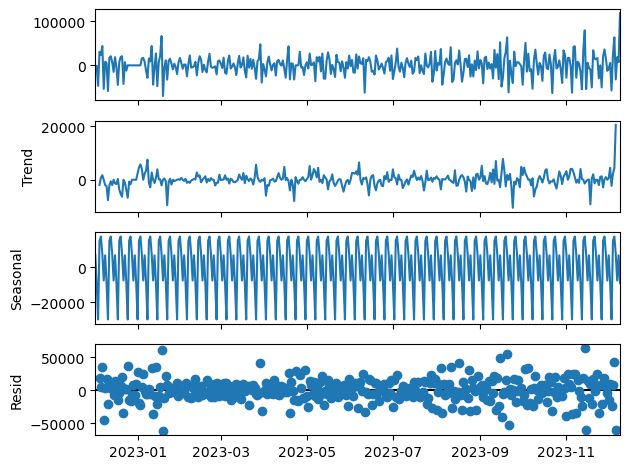

In [85]:
# y nuevamente vemos la descomposicion temporal
result = seasonal_decompose(df_stationary, model = 'additive', period = 7)
result.plot()
plt.show()

# los cambios respecto a la serie temporal original son que la tendencia y la estacionalidad han desaparecido. (graficos de trend y seasional son distintos)




<a id='seccion3'></a>
## **3. Modelaje ARIMA**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

El modelo se denomina modelo Autorregresivo Integrado de Medias Moviles de orden (p,d,q) o ARIMA(p,d,q),donde
- p:  es el orden del polinomio autorregresivo estacionario
- d: es el orden de integracion de la serie,es decir,el numero de diferencias que hay que tomar a la serie para que sea estacionaria
- q: es el orden del polinomio de medias moviles invertible.

Para datos no estacionarios, los valores en el model ARIMA (p, d, q) representan:
+ p: Número de observaciones de retraso incluidas en el modelo, también llamado orden de retraso
+ d: Número de veces que se diferencian las observaciones sin procesar, también llamado grado de diferenciación.
+ q: Tamaño de la ventana del promedio móvil, también llamado orden del promedio móvil.

En caso de tener datos estacionales, también debemos aplicar las diferencias estacionales. En este caso el modelo ARIMA se expresa como SARIMA e incluye un componente estacional (P, D, Q)


Usaremos un autoarima que ajusta los parametros a los mejores resultados.

In [86]:
# para la division entre train y test vamos a tomar 3 meses para el test.

df_train = df_stationary.head(df_stationary.shape[0] - 90)[['value']]
df_test = df_stationary.tail(90)[['value']]
print(df_stationary.shape)
print(df_train.shape)
print(df_test.shape)

(373, 1)
(283, 1)
(90, 1)


In [87]:
auto_arima_pax = auto_arima(df_train['value'],
                       start_P=1,
                       start_q=1,
                       max_p=3,
                       max_q=3,
                       m=7,  # Estacionalidad semanal
                       seasonal=True,
                       D=1, #Hemos hecho una diferenciacion
                       max_d=3,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
auto_arima_pax.summary()

# aqui el ARIMA lo hace automatico buscando los mejores hiperparametros. los parametros P Q suelen variar entre 0-5, la D son las diferenciacion. En nuestro caso lo hemos ajustado D=1 
# porque ya habiamos hecho una diferenciacion previa.

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[7] intercept   : AIC=6006.983, Time=1.19 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=6200.375, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=6126.730, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=6011.182, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=6198.464, Time=0.02 sec
 ARIMA(2,0,1)(0,1,1)[7] intercept   : AIC=6007.471, Time=0.92 sec
 ARIMA(2,0,1)(1,1,0)[7] intercept   : AIC=6068.747, Time=0.32 sec
 ARIMA(2,0,1)(2,1,1)[7] intercept   : AIC=6006.091, Time=2.47 sec


 ARIMA(2,0,1)(2,1,0)[7] intercept   : AIC=6053.652, Time=0.72 sec
 ARIMA(2,0,1)(2,1,2)[7] intercept   : AIC=6004.706, Time=2.85 sec
 ARIMA(2,0,1)(1,1,2)[7] intercept   : AIC=6008.098, Time=1.81 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(2,0,0)(2,1,2)[7] intercept   : AIC=inf, Time=2.09 sec
 ARIMA(3,0,1)(2,1,2)[7] intercept   : AIC=6006.601, Time=3.02 sec
 ARIMA(2,0,2)(2,1,2)[7] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=6062.604, Time=1.39 sec
 ARIMA(1,0,2)(2,1,2)[7] intercept   : AIC=inf, Time=2.77 sec
 ARIMA(3,0,0)(2,1,2)[7] intercept   : AIC=6009.043, Time=2.75 sec
 ARIMA(3,0,2)(2,1,2)[7] intercept   : AIC=inf, Time=3.14 sec
 ARIMA(2,0,1)(2,1,2)[7]             : AIC=6003.169, Time=1.73 sec
 ARIMA(2,0,1)(1,1,2)[7]             : AIC=6006.804, Time=0.95 sec
 ARIMA(2,0,1)(2,1,1)[7]             : AIC=6004.759, Time=0.89 sec
 ARIMA(2,0,1)(1,1,1)[7]             : AIC=6005.540, Time=0.42 sec
 ARIMA(1,0,1)(2,1,2)[7]            

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  283
Model:             SARIMAX(0, 0, 2)x(1, 1, [1], 7)   Log Likelihood               -2981.767
Date:                             Sat, 06 Apr 2024   AIC                           5973.534
Time:                                     12:54:41   BIC                           5991.636
Sample:                                 12-02-2022   HQIC                          5980.798
                                      - 09-10-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6797      0.063    -10.810      0.000      -0.803      -0.556
ma.L2         -0.0859      0.071     -1.215      0.225      -0.225       0.053
ar.S.L7        0.1535      0.051      3.012      0.003       0.054       0.253
ma.S.L7       -0.9242      0.033    -27.625      0.000      -0.990      -0.859
sigma2      1.373e+08   1.21e-10   1.14e+18      0.000    1.37e+08    1.37e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                31.87
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             0.52
Prob(H) (two-sided):                  0.28   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.48e+33. Standard errors may be unstable.
"""

In [88]:
# Segun el analisis AutoARIMA, los parametros que mejor funcionan son los siguietnes:

'''

Best model:  ARIMA(0,0,2)(1,1,1)[7]          
Total fit time: 56.875 seconds

'''
# ajustamos el modelo arima a los parametros correctos

model_auto = SARIMAX(df_train['value'],order=(0, 0, 2),
              seasonal_order=(1, 1, 1, 7),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_auto_arima = model_auto.fit()
print(results_auto_arima.summary())




                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                  283
Model:             SARIMAX(0, 0, 2)x(1, 1, [1], 7)   Log Likelihood               -2885.553
Date:                             Sat, 06 Apr 2024   AIC                           5781.106
Time:                                     12:54:41   BIC                           5799.024
Sample:                                 12-02-2022   HQIC                          5788.304
                                      - 09-10-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6879      0.101     -6.831      0.000      -0.885      -0.491
ma.L2         -0.0556      

In [89]:
#   Vamos a predecir los valores de test    


forecast_auto_arima = results_auto_arima.predict(start = len(df_train),
                           end=len(df_train)+90,
                           typ='levels').rename('forecast_auto_arima')



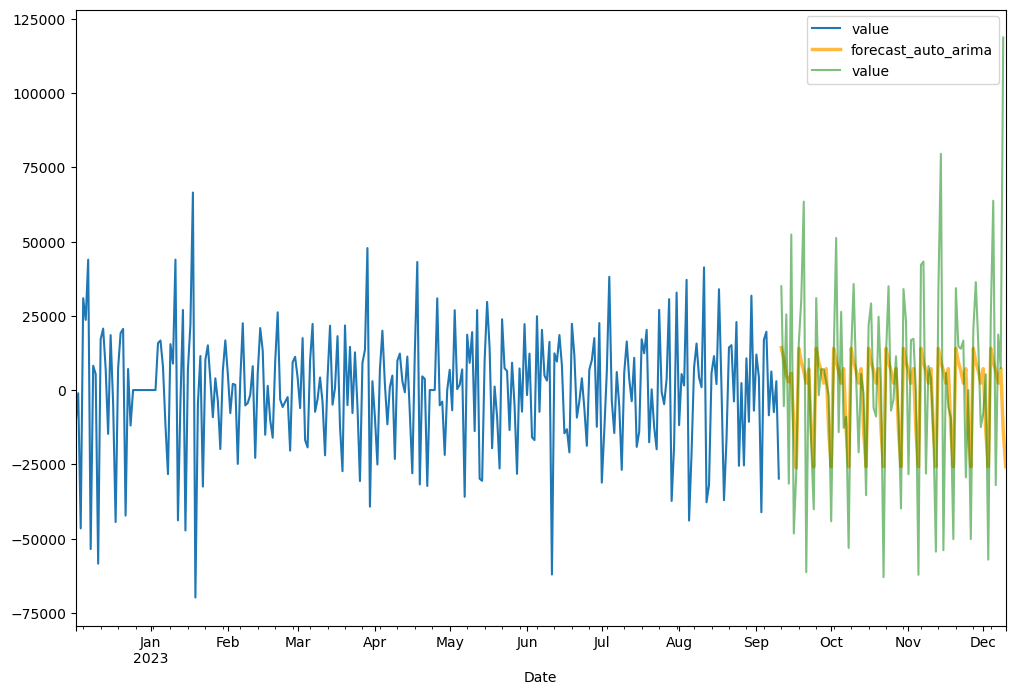

In [90]:
# Plot forecasts 
df_train['value'].plot(figsize=(12,8),legend=True)
forecast_auto_arima.plot(legend=True, color='orange', alpha=0.75, linewidth=2.5)
df_test['value'].plot(legend=True,color='green', alpha=0.5)

plt.show()

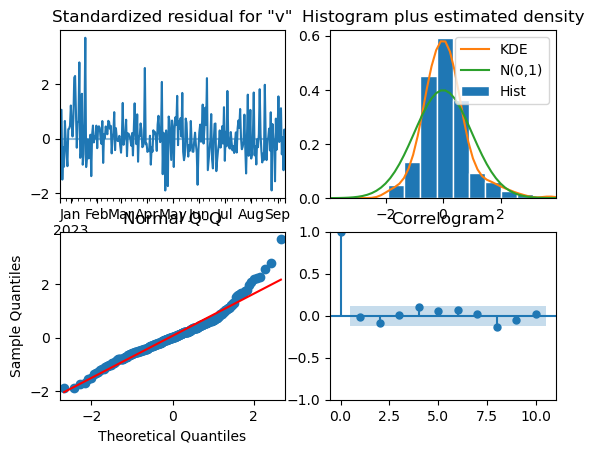

In [91]:
diag = results_auto_arima.plot_diagnostics()

In [92]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# Asegurémonos de que ambas series temporales tengan la misma longitud
min_length = min(len(forecast_auto_arima), len(df_test['value']))
forecast_auto_arima = forecast_auto_arima[:min_length]
df_test['value'] = df_test['value'][:min_length]

# Calculamos el RMSE
rmse = sqrt(mean_squared_error(y_pred=forecast_auto_arima, y_true=df_test['value']))
print(f'RMSE: {round(rmse, 3)}')


RMSE: 27709.363


<a id='seccion4'></a>
## **4. Modelaje Prophet**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">


Como no me han gustado mucho las predicciones del modelo de ARIMA, y aunque permite ajustar la finura y precision en los valores, son dificiles de interpretar. Vamos a usar Prophet de meta que permite tragar los datos sin necesidad de trasformaciones ni diferenciaciones.


Prophet nos permite capturar las tendencias, estacionalidades así como ajuste a vacaciones

In [15]:
# vamos a rescatar el df con toda la info ya preprocesada (fuera nulos y negativos)
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Hour,value,week_day,month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,2022-12-01,08:26:00,15.30,Thursday,December
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34,Thursday,December
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,2022-12-01,08:26:00,22.00,Thursday,December
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34,Thursday,December
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34,Thursday,December
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2023-12-09 12:50:00,0.85,12680.0,France,2023-12-09,12:50:00,10.20,Saturday,December
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2023-12-09 12:50:00,2.10,12680.0,France,2023-12-09,12:50:00,12.60,Saturday,December
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2023-12-09 12:50:00,4.15,12680.0,France,2023-12-09,12:50:00,16.60,Saturday,December
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2023-12-09 12:50:00,4.15,12680.0,France,2023-12-09,12:50:00,16.60,Saturday,December


In [16]:
df_prophet= df[['Date','value']]
df_prophet 

,Date,value
0,2022-12-01,15.30
1,2022-12-01,20.34
2,2022-12-01,22.00
3,2022-12-01,20.34
4,2022-12-01,20.34
...,...,...
541904,2023-12-09,10.20
541905,2023-12-09,12.60
541906,2023-12-09,16.60
541907,2023-12-09,16.60


In [17]:
df_prophet['Date']= pd.to_datetime(df_prophet['Date'])
df_prophet.dtypes

Date     datetime64[ns]
value           float64
dtype: object

In [18]:
# Step 1 & 2: Convert the 'date_column_name' to datetime format and set as index
df_prophet = df_prophet.set_index('Date')

# Step 3: Now that the DataFrame has a DatetimeIndex, resample it
df_prophet = df_prophet.resample('D').sum()
df_prophet= df_prophet.reset_index()

In [19]:
# renombramos las columnas

df_prophet= df_prophet.rename(columns={'Date':'ds','value':'y'})
df_prophet

,ds,y
0,2022-12-01,58669.59
1,2022-12-02,47611.42
2,2022-12-03,46550.38
3,2022-12-04,0.00
4,2022-12-05,30908.67
...,...,...
369,2023-12-05,87988.49
370,2023-12-06,55993.69
371,2023-12-07,74675.55
372,2023-12-08,82066.29


In [20]:
# Una vez tenemos el df en el formato correcto, vamos a dividirlo en train y test


# Usaremos los ultimos 3 meses como test y el resto para entrenamiento.

df_prophet_train = df_prophet.head(df_prophet.shape[0] - 90)
df_prophet_test = df_prophet.tail(90)


In [22]:
# ahora cargamos el modelo ajustando los parametros que considero interesantes (las vacaciones en el pais mas importante ,UK,
# el resto son por default)
model = Prophet()

# Añadir días festivos del Reino Unido.add_country_holidays('GB')
# model.add_country_holidays(country_name='GB')

# Ajustar el modelo a los datos de entrenamiento


model.fit(df_prophet_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
# vemos como ha predicho a 90 dias (para comparar con el test)

future= model.make_future_dataframe(periods=90)

forecast= model.predict(future)

In [ ]:
# ahora comparamos prediccion con valores reales
df_merge = pd.merge(df_prophet_test, forecast[['ds', 'yhat']], on='ds', how='inner')

In [ ]:
# Y visualizamos la prediccion


plt.figure(figsize=(10, 6))
plt.plot(df_merge['ds'], df_merge['y'], label='Real')
plt.plot(df_merge['ds'], df_merge['yhat'], label='Predicción', alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación de valores reales vs predicciones')
plt.legend()
plt.show()


In [46]:
# Prophet necesita que formateemos las columnas de una determinada forma. Necesita que las fechas esten en formato datetime y con nombre 'ds'
# a su vez necesita que la variable a predecir se llame 'y' ( en nuestro caso value)

df_prophet = df.copy()


# agrupamos por misma fecha de dia


# y cambiamos nomrbes de columnas clave

df_prophet.rename(columns={'Date':'ds','value':'y'},inplace=True)
df_prophet['ds']= pd.to_datetime(df_prophet['ds'])
df_prophet.set_index('ds', inplace=True)
df_prophet

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Hour,y,week_day,month
ds,,,,,,,,,,,,
2022-12-01,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.00,United Kingdom,08:26:00,15.30,Thursday,December
2022-12-01,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.00,United Kingdom,08:26:00,20.34,Thursday,December
2022-12-01,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.00,United Kingdom,08:26:00,22.00,Thursday,December
2022-12-01,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.00,United Kingdom,08:26:00,20.34,Thursday,December
2022-12-01,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.00,United Kingdom,08:26:00,20.34,Thursday,December
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-09,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2023-12-09 12:50:00,0.85,12680.00,France,12:50:00,10.20,Saturday,December
2023-12-09,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2023-12-09 12:50:00,2.10,12680.00,France,12:50:00,12.60,Saturday,December
2023-12-09,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2023-12-09 12:50:00,4.15,12680.00,France,12:50:00,16.60,Saturday,December


In [48]:
# Una vez tenemos el df en el formato correcto, vamos a dividirlo en train y test


# Usaremos los ultimos 3 meses como test y el resto para entrenamiento.

df_prophet_train = df_prophet.head(df_prophet.shape[0] - 90)
df_prophet_test = df_prophet.tail(90)



In [52]:
# prophet necesita que cambiemos los nombres de las columnas target de nuestro dataframe df, crearemos uno especifico para prophet, df_prophet

'''class Prophet(freq=None, add_seasonality=None, add_country_holidays=None, growth='linear', 
                growth_floor=0.0, growth_cap=None, changepoints=None, n_changepoints=25, changepoint_range=0.8,
                  yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, 
                  seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, 
                  changepoint_prior_scale=0.05, mcmc_samples=0, alpha=0.05, uncertainty_samples=1000, 
                  stan_backend=None, verbose=0, fit_kwargs=None)'''


"class Prophet(freq=None, add_seasonality=None, add_country_holidays=None, growth='linear', \n                growth_floor=0.0, growth_cap=None, changepoints=None, n_changepoints=25, changepoint_range=0.8,\n                  yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, \n                  seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, \n                  changepoint_prior_scale=0.05, mcmc_samples=0, alpha=0.05, uncertainty_samples=1000, \n                  stan_backend=None, verbose=0, fit_kwargs=None)"

In [49]:
# ahora cargamos el modelo ajustando los parametros que considero interesantes (las vacaciones en el pais mas importante ,UK,
# el resto son por default)
model = Prophet()

# Añadir días festivos del Reino Unido.add_country_holidays('GB')
# model.add_country_holidays(country_name='GB')

# Ajustar el modelo a los datos de entrenamiento


model.fit(df_prophet_train)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [53]:
# ahora cargamos el modelo ajustando los parametros que considero interesantes (las vacaciones en el pais mas importante ,UK,
# el resto son por default)
model = Prophet(growth='linear', seasonality_mode='additive', changepoint_prior_scale=0.05,
                holidays_prior_scale=10.0, seasonality_prior_scale=10.0, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,
                mcmc_samples=0, uncertainty_samples=1000).add_country_holidays(country_name='GB')

# Añadir días festivos del Reino Unido
model.add_country_holidays(country_name='GB')

# Ajustar el modelo a los datos de entrenamiento
model.fit(df_prophet_train)


TypeError: 'in <string>' requires string as left operand, not NoneType

In [52]:
import holidays

In [1]:
# ahora cargamos el modelo ajustando los parametros que considero interesantes (basicamente la frecuencia y las vacaciones en el pais mas importante ,UK,
# el resto son por default)

model_prof= Prophet(freq='D', growth='linear', add_country_holidays= {'country_name': 'United Kingdom'}  ,seasonality_mode='additive', changepoint_prior_scale=0.05,
                holidays_prior_scale=10.0, seasonality_prior_scale=10.0, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, holidays=None,
                  mcmc_samples=0, uncertainty_samples=1000, stan_backend=None, verbose=0, fit_kwargs=None)

# ajustamos el modelo a los datos de entrenamiento
model_prof.fit(df_prophet_train)

NameError: name 'Prophet' is not defined

In [ ]:
# make an in-sample forecast
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot
# load data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = read_csv(path, header=0)
# prepare expected column names
df.columns = ['ds', 'y']
df['ds']= to_datetime(df['ds'])
# define the model
model = Prophet()
# fit the model
model.fit(df)
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
 date = '1968-%02d' % i
 future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

XGBOOST


In [ ]:
# Supongamos que df_ax es tu DataFrame con la columna 'value' y 'date'
# Asegúrate de tener tu DataFrame ordenado por fecha antes de realizar la división
df_ax = df_ax.sort_values(by='Date')

# Calcula el índice para dividir tus datos
split_index = int(0.75 * len(df_ax))  # El 75% para entrenamiento, 25% para prueba (desde septiembre digamos)

# Divide los datos
y_train = df_ax.iloc[:split_index]
y_test = df_ax.iloc[split_index:]

# Muestra la forma y las primeras y últimas filas de los conjuntos de entrenamiento y prueba
display(train_data.shape, train_data.head(2), train_data.tail(2))
display(test_data.shape, test_data.head(2), test_data.tail(2))


(280, 1)

,value
Date,
2022-12-01,54613.88
2022-12-02,47451.57


,value
Date,
2023-09-05,25786.19
2023-09-06,22884.43


(94, 1)

,value
Date,
2023-09-07,28093.48
2023-09-08,19828.28


,value
Date,
2023-12-08,78998.25
2023-12-09,196114.48


## Definición del horizonte de pronóstico

- Consideramos la muestra de evaluación  

- Empezamos con pronósticos dentro de la muestra

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.forecasting.model_evaluation import evaluate
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_error

import xgboost as xgb

from xgboost import XGBRegressor 


from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import (
    TransformedTargetForecaster)
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, SingleWindowSplitter, ExpandingWindowSplitter, ForecastingGridSearchCV 
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

ImportError: cannot import name 'SingleWindowSplitter' from 'sktime.forecasting.model_selection' (c:\Users\Usuario\anaconda3\Lib\site-packages\sktime\forecasting\model_selection\__init__.py)

In [ ]:
# Forecasting horizon

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)
fh


ForecastingHorizon(['2023-09-07', '2023-09-08', '2023-09-09', '2023-09-10',
               '2023-09-11', '2023-09-12', '2023-09-13', '2023-09-14',
               '2023-09-15', '2023-09-16', '2023-09-17', '2023-09-18',
               '2023-09-19', '2023-09-20', '2023-09-21', '2023-09-22',
               '2023-09-23', '2023-09-24', '2023-09-25', '2023-09-26',
               '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30',
               '2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04',
               '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08',
               '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12',
               '2023-10-13', '2023-10-14', '2023-10-15', '2023-10-16',
               '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20',
               '2023-10-21', '2023-10-22', '2023-10-23', '2023-10-24',
               '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-28',
               '2023-10-29', '2023-10-30', '2023-10-31', '2023-11-01',
 

### Naive

In [ ]:
forecaster = NaiveForecaster(strategy="last") # last, mean, drift --> estrategias de naive forecaster. Last es similar a recursive en 'xgboost'
forecaster.fit(y_train)
y_pred_naive = forecaster.predict(fh)

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be re

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

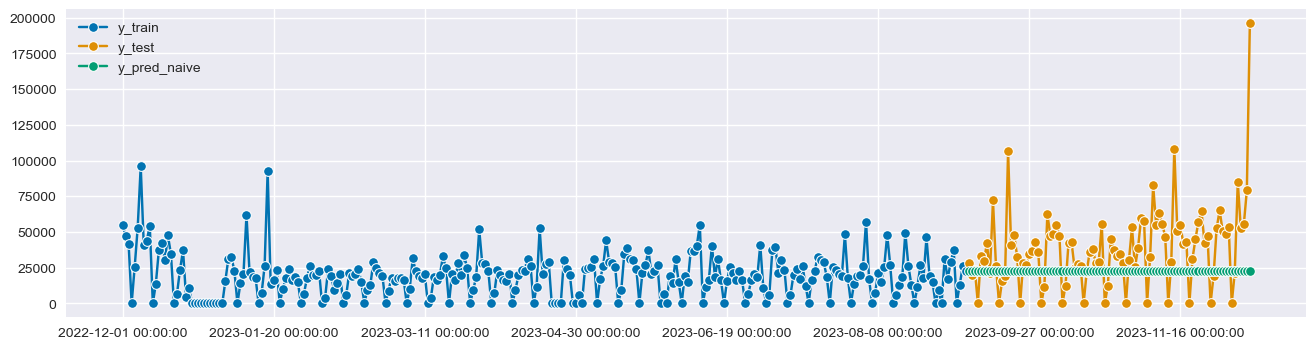

In [ ]:
plot_series(y_train, y_test, y_pred_naive, labels=["y_train", "y_test", "y_pred_naive"])

- Sale una línea porque el modelo está considerando únicamente el último valor de la serie temporal para hacer la predicción.

- No es muy informativo, hay que modificar la muestra de datos que queremos que considere el modelo para predecir. 

- Vamos introducir una periodicidad estacional (sp) de 5 (según lo que hemos visto en el gráfico PACF) 

In [ ]:
forecaster = NaiveForecaster(strategy="last", sp=5)
forecaster.fit(y_train)
y_pred_naive_imp = forecaster.predict(fh)


c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be re

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

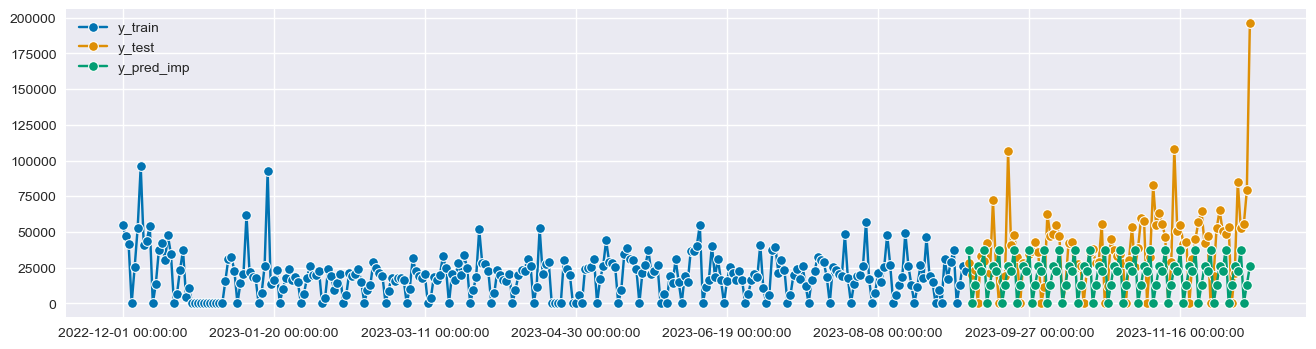

In [ ]:
plot_series(y_train, y_test, y_pred_naive_imp, labels=["y_train", "y_test", "y_pred_imp"])

### XGBoost

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be re

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

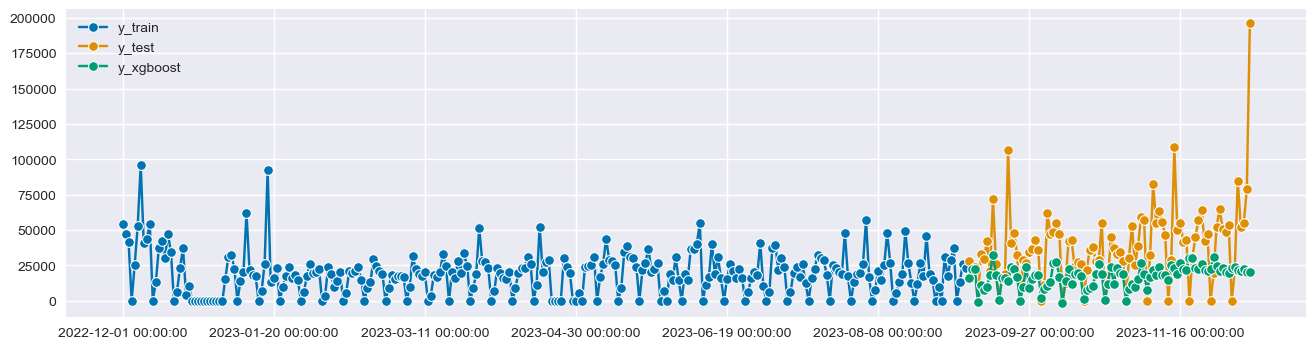

In [ ]:
from xgboost import XGBRegressor 


xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster_xgb = make_reduction(xgb_regressor, strategy="recursive") # recursive, direct, mulitoutput
forecaster_xgb.fit(y_train)
y_pred_xgboost = forecaster_xgb.predict(fh)
plot_series(y_train, y_test, y_pred_xgboost, labels=["y_train", "y_test","y_xgboost"])

### KNN 

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be re

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

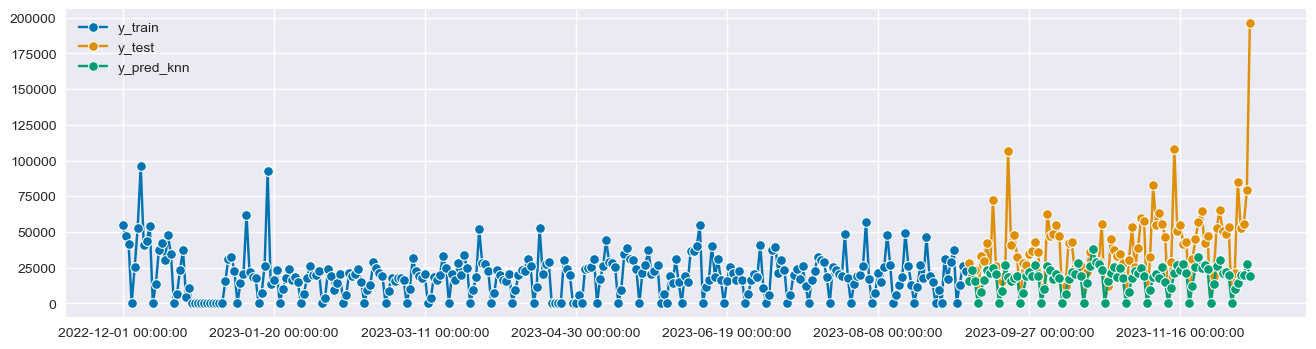

In [ ]:
regressor = KNeighborsRegressor(n_neighbors=4)
forecaster = make_reduction(regressor, strategy="recursive", window_length=7)
forecaster.fit(y_train.dropna(), fh=fh)
y_pred_knn = forecaster.predict()
plot_series(y_train, y_test, y_pred_knn, labels=["y_train", "y_test", "y_pred_knn"])

## Evaluación de los modelos

In [ ]:
mae_naive = mean_absolute_error(y_test, y_pred_naive)
mae_naive_imp = mean_absolute_error(y_test, y_pred_naive_imp)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

# create data frame with mape values

maes = [mae_naive, mae_naive_imp,  mae_xgboost, mae_knn]
models = ['Naive', 'Naive Improved', 'XGBoost', 'KNN']

pd.DataFrame({'Model': models, 'MAE': maes}).sort_values(by='MAE', ascending=True)


,Model,MAE
3,KNN,21270.188721
0,Naive,22928.813532
2,XGBoost,23497.765677
1,Naive Improved,26189.259277


#### Transformadores

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_evaluation import evaluate

from sktime.forecasting.compose import make_reduction
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error


from xgboost import XGBRegressor 


from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import (
    TransformedTargetForecaster)
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, ExpandingWindowSplitter
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer, Detrender


import warnings 
warnings.filterwarnings('ignore')

In [ ]:
y_train['value']= y_train['value']+1

In [ ]:
# Source: Full set of transformers is in here: https://sktime-backup.readthedocs.io/en/v0.13.0/api_reference/transformations.html#


xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

# fit a forecaster with transformers aimed at deseasonalizing and detrending the data
forecaster = forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize_year", Deseasonalizer(model="multiplicative", sp=12)),
        ('LogTransformer', LogTransformer()),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(xgb_regressor, window_length=12, scitype='tabular-regressor')),
        
    ]
    
)

forecaster.fit(y_train)
y_pred_transf = forecaster.predict(fh)


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

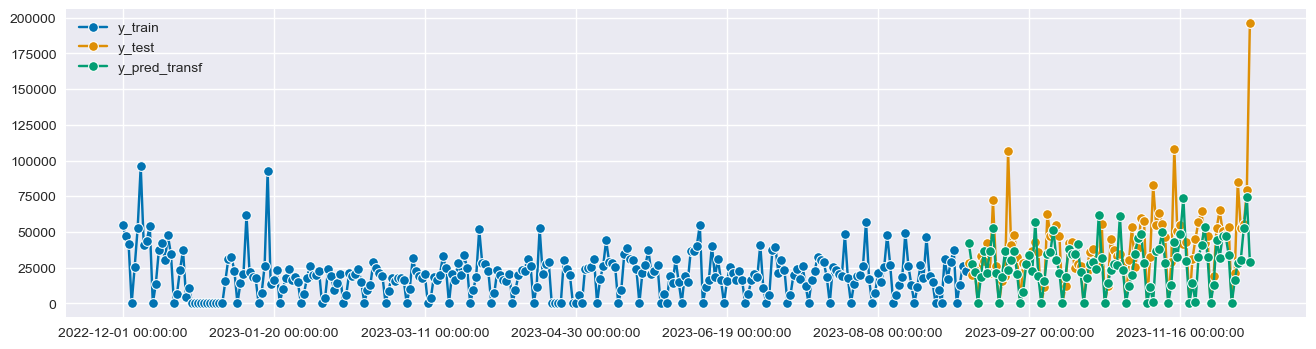

In [ ]:
plot_series(y_train, y_test, y_pred_transf, labels=["y_train", "y_test", "y_pred_transf"])

In [ ]:
mape_xgb_transf = mean_absolute_percentage_error(y_test, y_pred_transf, symmetric=False)
mae_xgb_transf = mean_absolute_error(y_test, y_pred_transf)
rmse_xgb_transf = mean_squared_error(y_test, y_pred_transf, squared=True)

eval_xgb_transf = [mape_xgb_transf, mae_xgb_transf, rmse_xgb_transf]
pd.DataFrame(eval_xgb_transf, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb'])

,eval_xgb
MAPE,9.316386e+14
MAE,1.601108e+04
RMSE,7.483278e+08


####  Tunear hiperparametros, utilizar validación cruzada y re-entrenar

Hay que definir varias cosas

- El conjunto de hiperparámetros a tunear

- La forma en que vamos a dividir la serie temporal para llevar a cabo la validación cruzada. 







In [ ]:
# Definimos el tamaño de la muestra para hacer la validación

validation_size = len(y_test)
validation_size


94

In [ ]:
# Definimos muestra para la validación cruzada 

cv = ExpandingWindowSplitter(initial_window=36,
                                step_length=12,
                             fh=validation_size)

In [ ]:
# mantener estos parametros, es con lo que mejor funciona segun el.

param_grid = {
    'forecast__estimator__max_depth': [3, 5, 6, 10, 15],
    'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__n_estimators': [100, 200, 300, 500, 1000]
}


rscv = ForecastingRandomizedSearchCV(forecaster, 
                                     cv=cv, 
                                     param_distributions=param_grid,
                                     n_iter=100, 
                                     random_state=42,
                                     error_score='raise',
                                     n_jobs=-1)


In [ ]:
result_cv = rscv.fit(y_train)

y_pred_transf_cv = rscv.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

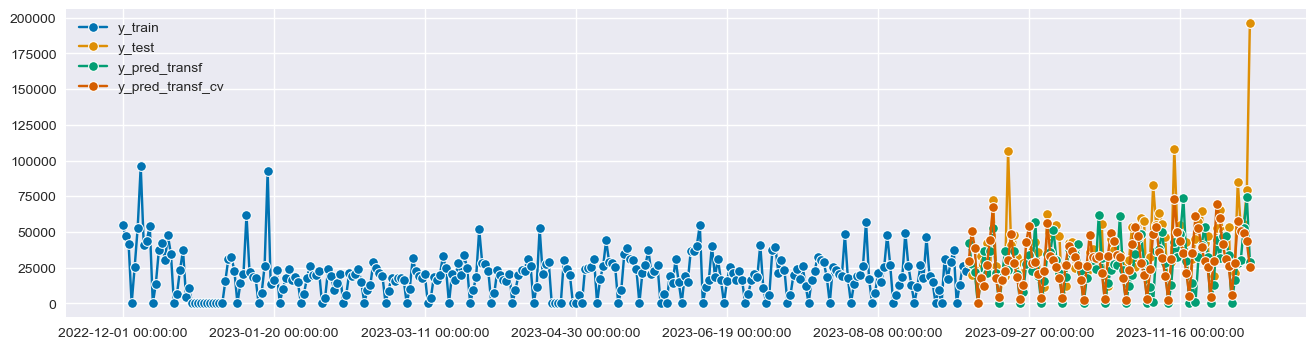

In [ ]:
plot_series(y_train, y_test,  y_pred_transf, y_pred_transf_cv, labels=["y_train", "y_test", "y_pred_transf", "y_pred_transf_cv"])

Vemos que tras la cv ha mejorado la grafica bastante

In [ ]:
# Evaluacion 


mape_xgb_transf_cv = mean_absolute_percentage_error(y_test, y_pred_transf_cv, symmetric=False)
mae_xgb_transf_cv = mean_absolute_error(y_test, y_pred_transf_cv)
rmse_xgb_transf_cv = mean_squared_error(y_test, y_pred_transf_cv, squared=True)

eval_xgb_transf_cv = [mape_xgb_transf_cv, mae_xgb_transf_cv, rmse_xgb_transf_cv]
pd.DataFrame(eval_xgb_transf_cv, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb_transf_cv'])

,eval_xgb_transf_cv
MAPE,2.071648e+18
MAE,1.479928e+04
RMSE,6.236473e+08


### Pronóstico fuera de la muestra

In [ ]:
y_test

,value
2023-09-07,28093.48
2023-09-08,19828.28
2023-09-09,23620.43
2023-09-10,0.00
2023-09-11,33440.65
...,...
2023-12-05,84911.52
2023-12-06,52473.05
2023-12-07,55214.81
2023-12-08,78998.25


In [ ]:
fhos = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2023-09-07", periods=180, freq="D")), is_relative=False
)
fhos


# definimos el horizonte de pronostico a 3 meses

ForecastingHorizon(['2023-09-07', '2023-09-08', '2023-09-09', '2023-09-10',
             '2023-09-11', '2023-09-12', '2023-09-13', '2023-09-14',
             '2023-09-15', '2023-09-16',
             ...
             '2024-02-24', '2024-02-25', '2024-02-26', '2024-02-27',
             '2024-02-28', '2024-02-29', '2024-03-01', '2024-03-02',
             '2024-03-03', '2024-03-04'],
            dtype='period[D]', length=180, is_relative=False)

In [ ]:
rscv.fit(y_train)
y_pred_transf_oos = rscv.predict(fhos)

AssertionError: 

No consigo resolver un fallo que me da. pero desde aqui evaluaria cómo de creible es nuestro modelo de cara a los 3 meses a predecir.

In [ ]:
plot_series(y_train, y_test, y_pred_transf_oos, labels=["y_train", "y_test", "y_pred_transf_oos"])


NameError: name 'y_pred_transf_oos' is not defined

## Comentarios

Me ha resultado bastante dificil entender esta parte de Time Series. No obstante he conseguido llegar más alla de lo que inicialmente pensaba que llegaría.

Los conceptos generales los entiendo bien, pero me veo asaltado por multitud de errores (que no deberian pasar) por incompatibilidades de bibliotecas entiendo, que en definitiva me ha hecho mucho mas dificil, lento y espeso el avance del proyecto. A decir verdad algo frustrado o desesperado cuando ocurrian.

Estoy seguro que con tiempo y calma podré tanto profundizar como reforzar todos los conceptos, pero por el momento es lo que hay.

Saludos y gracias por la info.


# Añadimos transformadores

- Idea: Incorporar el pre procesamiento de los datos como parte del `forecaster`




In [232]:
from sktime.forecasting.model_selection import SingleWindowSplitter


ImportError: cannot import name 'SingleWindowSplitter' from 'sktime.forecasting.model_selection' (c:\Users\Usuario\anaconda3\Lib\site-packages\sktime\forecasting\model_selection\__init__.py)

In [230]:
# Pipeline ---------------

# Define the forecasting horizon
from sktime.transformations.series.boxcox import BoxCoxTransformer


fh = ForecastingHorizon(y_test.index, is_relative=False)
validation_size = len(y_test) # necesaria para hacer la validiación cruzada
cv = SingleWindowSplitter(window_length=len(accidentes_2023)-validation_size,  # training window length
                          fh=validation_size) # forecasting horizon



# Ajusta el regresor y los transformadores que necesitemos
# Source: https://www.sktime.net/en/stable/api_reference/transformations.html
regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize_week", Deseasonalizer(model="additive", sp=5)),         # desestacionaliza cada 5 días
        ("deseasonalize_month", Deseasonalizer(model="additive", sp=30)),        # desestacionaliza cada 30 días
        ('LogTransformer', BoxCoxTransformer(method= 'guerrero', sp=5)),         # corrige heterocedasticidad. aplicamos sp si utlizamos guerrero si no, no hace falta y utiliza mle como método por defecto para estimar lambda
        ('HampelFilter', HampelFilter(window_length=30)),                       # suaviza outliers
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=3))), # elimina tendencia
        ("forecast", make_reduction(regressor, window_length=30, scitype='tabular-regressor')), # ajusta el modelo considerando los últimos 30 días 
        
    ]
)


model= make_reduction(regressor, window_length=30,  scitype='tabular-regressor')



param_grid = {
    'estimator__max_depth': [3, 5, 6, 10, 15, 20,30],
    'estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'estimator__n_estimators': [100,200,300, 500, 1000]
}
gscv = ForecastingRandomizedSearchCV(model, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42,error_score='raise',n_jobs=-1)

gscv.fit(y_train)
y_pred_cv_xgb = gscv.predict(fh)

NameError: name 'SingleWindowSplitter' is not defined

Me encuentro con distintos errores que me hacen imposible progresar en la evolucion del proyecto:


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[230], line 9
      7 fh = ForecastingHorizon(y_test.index, is_relative=False)
      8 validation_size = len(y_test) # necesaria para hacer la validiación cruzada
----> 9 cv = SingleWindowSplitter(window_length=len(accidentes_2023)-validation_size,  # training window length
     10                           fh=validation_size) # forecasting horizon
     14 # Ajusta el regresor y los transformadores que necesitemos
     15 # Source: https://www.sktime.net/en/stable/api_reference/transformations.html
     16 regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

NameError: name 'SingleWindowSplitter' is not defined

In [ ]:
df_k_mensual['date'] = df_k_mensual.index
df_k_mensual['dayofweek'] = df_k_mensual['date'].dt.dayofweek
df_k_mensual['quarter'] = df_k_mensual['date'].dt.quarter
df_k_mensual['month'] = df_k_mensual['date'].dt.month
df_k_mensual['year'] = df_k_mensual['date'].dt.year
df_k_mensual['dayofyear'] = df_k_mensual['date'].dt.dayofyear
df_k_mensual['dayofmonth'] = df_k_mensual['date'].dt.day
df_k_mensual['weekofyear'] = df_k_mensual['date'].dt.isocalendar().week.astype(int)

X = df_k_mensual[['dayofweek','quarter','month','year',
        'dayofyear','dayofmonth','weekofyear']]

y = df_k_mensual[['Temp_2m']]


In [ ]:
X_train = X.head(X.shape[0] - 12)
X_test = X.tail(12)
y_train = y.head(X.shape[0] - 12)
y_test = y.tail(12)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(456, 7)
(12, 7)
(456, 1)
(12, 1)


In [ ]:
y_test

,Temp_2m
Date,
2019-01-31,8.624839
2019-02-28,10.590357
2019-03-31,14.169355
2019-04-30,19.123333
2019-05-31,22.096774
2019-06-30,23.275667
2019-07-31,21.499032
2019-08-31,21.316774
2019-09-30,19.507333


In [ ]:
X_train.dtypes

dayofweek     int64
quarter       int64
month         int64
year          int64
dayofyear     int64
dayofmonth    int64
weekofyear    int32
dtype: object

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=200,objective='reg:squarederror', random_state=42)
model_xgb.fit(X_train, y_train,verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

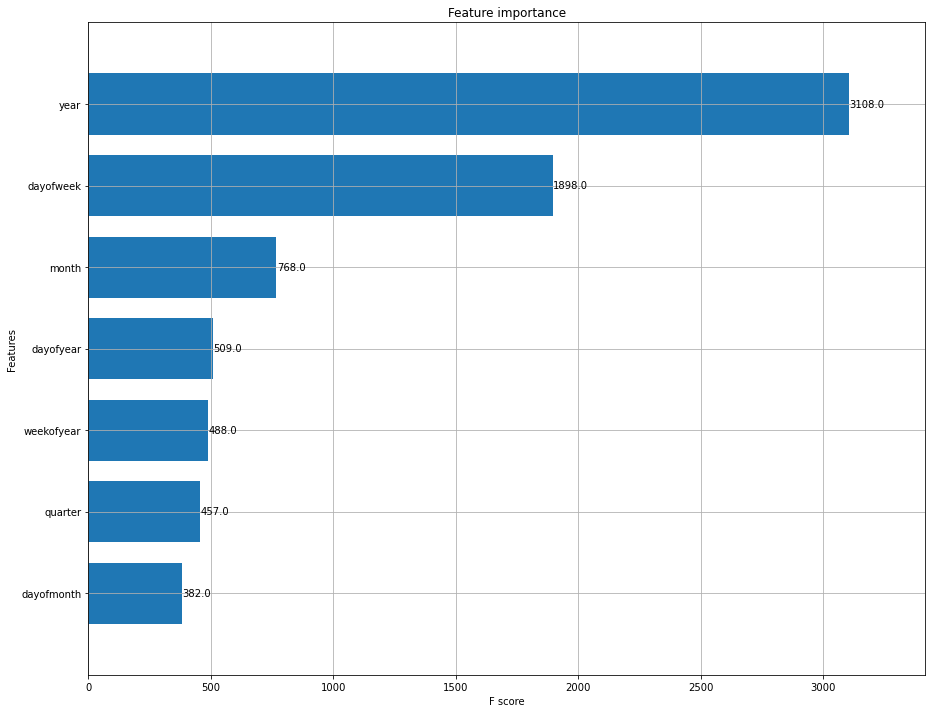

In [ ]:
_ = plot_importance(model_xgb, height = 0.75)

In [ ]:
y_pred = model_xgb.predict(X_test)
y_pred

array([ 8.588515, 12.005308, 15.735266, 18.600266, 20.673311, 22.018248,
       21.301277, 21.009037, 19.259823, 16.298391, 13.732845,  9.7744  ],
      dtype=float32)

In [ ]:
rmse = sqrt(mean_squared_error(y_pred = y_pred, y_true = y_test['Temp_2m']))
print(f'RMSE: {round(rmse,3)}')

RMSE: 0.965


In [ ]:
df = df_k_mensual.copy()
df

,Temp_2m,Diferencia,observed,trend,seasonal,resid,estimated,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,
1981-01-31,7.498387,NaN,7.498387,NaN,-8.136620,NaN,NaN,1981-01-31,5,1,1,1981,31,31,5
1981-02-28,11.256429,NaN,11.256429,NaN,-5.909298,NaN,NaN,1981-02-28,5,1,2,1981,59,28,9
1981-03-31,14.476129,NaN,14.476129,NaN,-1.533356,NaN,NaN,1981-03-31,1,1,3,1981,90,31,14
1981-04-30,18.382333,NaN,18.382333,NaN,2.828913,NaN,NaN,1981-04-30,3,2,4,1981,120,30,18
1981-05-31,20.994516,NaN,20.994516,NaN,5.205792,NaN,NaN,1981-05-31,6,2,5,1981,151,31,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,21.316774,0.410000,21.316774,NaN,4.140305,NaN,NaN,2019-08-31,5,3,8,2019,243,31,35
2019-09-30,19.507333,-0.384000,19.507333,NaN,2.813324,NaN,NaN,2019-09-30,0,3,9,2019,273,30,40
2019-10-31,16.337419,0.467097,16.337419,NaN,-0.021482,NaN,NaN,2019-10-31,3,4,10,2019,304,31,44


In [ ]:
df.index.max()

Timestamp('2019-12-31 00:00:00', freq='M')

Entrenamiento de XGBOOST con Split Cross Validation

In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(X_train.index.min(), X_train.index.max())

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

print(f"Promedio RMSE: {sum(rmse_scores) / len(rmse_scores)}")


1981-01-31 00:00:00 1987-06-30 00:00:00
1981-01-31 00:00:00 1993-12-31 00:00:00


1981-01-31 00:00:00 2000-06-30 00:00:00
1981-01-31 00:00:00 2006-12-31 00:00:00
1981-01-31 00:00:00 2013-06-30 00:00:00
Promedio RMSE: 1.0829442140382972


In [ ]:
# Fit the best model to the data

model_auto = SARIMAX(df_train['value'],order=(3, 0, 2),
              seasonal_order=(1, 0, 1, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_auto_arima = model_auto.fit()

In [ ]:
# TRANSFORMACION PARA ELIMINAR TENDENCIA
# Aplicar transformación logarítmica
df_log = np.log(df_stationary['value'])

# Verificar estacionaridad
result_log = adfuller(df_log)
result_log


c:\Users\Usuario\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

invalid value encountered in log



MissingDataError: exog contains inf or nans

ValueError: could not broadcast input array from shape (305,) into shape (366,)

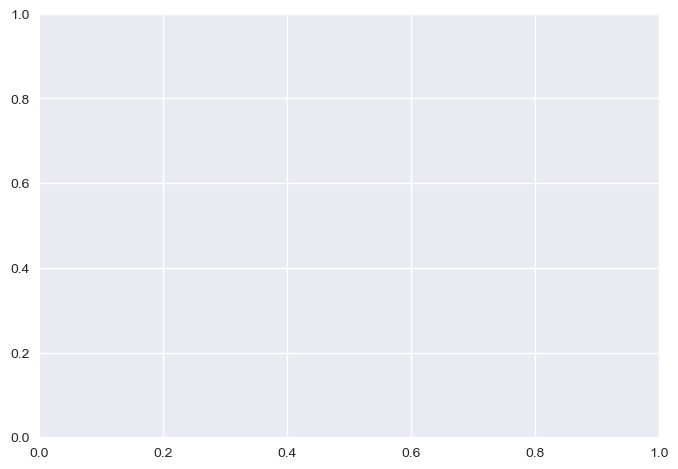

In [ ]:
# Plot the ACF and PACF of the generated TS
plot_acf(df_ax, lags=365)
plot_pacf(df_ax, lags=365)
plt.show

![Aqui he incluido una captura de pantalla de la diapositiva con el esquema de las etapas de la checklist de ML, está en local asi que no lo podrás ver. Lo he hecho para organización personal](cosas_que_hacer.PNG)